### Game Recommendation System

##### Content Page

In [1]:
import mysql.connector as mysql #pip install mysql.connector 
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import requests
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE , ADASYN # for imbalanced data
from imblearn.combine import SMOTEENN 
from imblearn.pipeline import make_pipeline
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from decimal import Decimal

### Content-based recommendation

recommending based on similarity score based on game plot/ description , developers, related genres,platforms

In [2]:
#Get dataset
gamedata = pd.read_csv("../SteamUserData/steamdata_cleanWithHIT.csv")

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

gamedata['additional_tags'] = gamedata['additional_tags'].apply(clean_data)

def join_tgt(x):
    return ''.join(str.lower(x['genres'])) + ' ' + ''.join(str.lower(x['developer'])) + ' ' + x['platforms'] + ' ' + ''.join(x['additional_tags'])

gamedata['joined'] = gamedata.apply(join_tgt, axis=1)


We will use cosine similarity to calculate the score for the similarity of the games


In [154]:
#Remove all english stop words such as 'the', 'a'
count = CountVectorizer(stop_words='english')

#fitting and transforming the data
count_matrix = count.fit_transform(gamedata['joined'])

## Compute the cosine similarity matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

metadata = gamedata.reset_index()
#reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['name'])

In [31]:
def get_recommendations(game, cosine_sim,howMany):
    # Get the index of the movie that matches the title
    idx = indices[game]

    # Get the pairwsie similarity scores of all games with that game
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the games based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar games
    howMany +=1
    sim_scores = sim_scores[1:int(howMany)]
    
    game_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    scores = pd.DataFrame(sim_scores, columns=list('ab'))
    counter = 0
    # Return the top 10 most similar games
    for x in gamedata['name'].iloc[game_indices]:
        print(x + " | Score : " + str(scores['b'][counter]))
        counter +=1
    
    return None;

#get_recommendations('Counter-Strike', cosine_sim2)

Fav_Games = input("Type in the games you play and the rating (0-10)(e.g Counter-Strike,9.5): ")
Fav_Games = Fav_Games.split(",")
dictGames = {}
for x in range(len(Fav_Games)):
    if(Fav_Games[x].isdigit() or "." in Fav_Games[x]):
        dictGames[Fav_Games[x-1]] = Decimal(Fav_Games[x])
        
if len(dictGames) <3:
    print("Games that you might like (Recommendation) : ")
    for x in dictGames:
        get_recommendations(x, cosine_sim2,10/len(dictGames))
else:
    print("Games that you might like (Recommendation) : ")
    dictGames = sorted(dictGames, key=dictGames.get, reverse=True)[:3]
    for x in dictGames:
        get_recommendations(x, cosine_sim2,3)

Games that you might like (Recommendation) : 
Counter-Strike: Source | Score : 0.7391304347826088
Counter-Strike: Condition Zero | Score : 0.6956521739130436
Day of Defeat | Score : 0.6384423980690613
Prime World | Score : 0.7862158588810493
Strife® | Score : 0.7171087882915775
Ball 3D: Soccer Online | Score : 0.6666666666666669
Half-Life: Source | Score : 0.8749999999999998
Half-Life: Opposing Force | Score : 0.7916666666666665
Half-Life 2 | Score : 0.7916666666666665


Now lets do a prediction model based collaborative filtering. Collaborative filtering is another way to make a recomendation model

We have the players data and the list of games the players own and ratings, we will use that to build our model

We will use TruncatedSVD to make our model

In [ ]:
#Database Connection (dont run this again , too costly!!) #Getting Data
db_connection = mysql.connect(user="root", password="jajasauce", host="34.143.214.112", database="steam")
cur = db_connection.cursor()

cur.execute("SELECT steamid,personaname FROM Player_Summaries WHERE personastate != 0 LIMIT 100000;") # We shall only limit it to 100,000 because of the large dataset
myresult = cur.fetchall()
df = pd.DataFrame(myresult,columns=['steamid','personaname'])
df.to_csv('playerinfo.csv', index=False) #We exported it to a csv file

API = "4141070D32E9CF793B1D9BC8A25C5950"

steam_data = pd.read_csv("SteamUserData/playerInfo.csv",nrows=20000) #We found out that 100,000 data is too much because each user could have thousands of games, and with just 20,000 users, there is already 500,000 data

#Getting list of User game library data
data1 = {'steamid':[],'gamesid':[],'playtime_forever':[]}
dfGames = pd.DataFrame(data1)

for x in steam_data['steamid']:
    response = requests.get("http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key="+API+"&steamid="+str(x)+"&format=json")
    reply = response.json(); 
    if(reply['response'] == {}):
        continue
    else:
        for y in reply['response']['games']: # save it to data frame instead
            new_row = {'steamid':str(x),'gamesid':y['appid'],'playtime_forever':y['playtime_forever']}
            dfGames = dfGames.append(new_row, ignore_index=True)
          
    
dfGames.to_csv('../SteamUserData/playerGames.csv', index=False)   

In [84]:
from random import choices
userData = pd.read_csv("../SteamUserData/PlayerGames.csv")


userData['rating'] = np.random.choice(np.arange(1, 6),userData.shape[0], p=[ 0.1, 0.2, 0.25, 0.25, 0.2])

userData.to_csv('../SteamUserData/PlayerGames.csv', index=False)

In [85]:
userData = pd.read_csv("../SteamUserData/PlayerGames.csv")

rating_crosstab = userData.pivot_table(values='rating', index='steamid', columns='gamesid', fill_value=0)
rating_crosstab

gamesid,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,100.0,130.0,...,433850.0,434570.0,439190.0,443080.0,446620.0,448280.0,450540.0,451520.0,457320.0,457960.0
steamid,,,,,,,,,,,,,,,,,,,,,
76561197960269742,4,4,5,2,4,4,4,5,2,1,...,0,0,0,0,5,2,5,3,1,4
76561197960270817,3,5,4,2,2,3,5,3,2,2,...,0,0,1,0,0,0,5,0,0,4
76561197960270881,1,5,3,3,5,4,2,1,2,5,...,2,0,0,5,0,0,0,0,0,0
76561197960271173,2,1,3,4,3,2,4,0,0,4,...,1,5,0,0,0,0,0,0,0,0
76561197960271217,4,5,2,3,4,2,3,4,1,2,...,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561197960410700,1,1,4,3,5,2,3,0,0,3,...,0,0,0,0,0,0,0,0,0,0
76561197960412986,3,3,5,4,5,4,3,0,0,4,...,0,0,3,0,0,0,0,0,0,0
76561197960413532,2,3,4,3,2,4,2,3,5,4,...,0,0,0,0,0,0,0,0,0,0


We will first Transpose the Matrix and after that use SVD to decompose it down to synthetic representations of the user ratings

In [86]:
X = rating_crosstab.T

### Decomposing the matrix - Using truncatedSVD

We will now perform a Truncated SVD on our user ratings Matrix in order to better estimate the ratings of user. the matrix will then represent a generalized view of users' tastes.

In [87]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=400)
#SVD.fit(X)
result_matrix = SVD.fit_transform(X)    
sum(SVD.explained_variance_ratio_)

0.9577503764064726

We get an explained variance of 95%

Let us now visiualise the data using TSNE. 

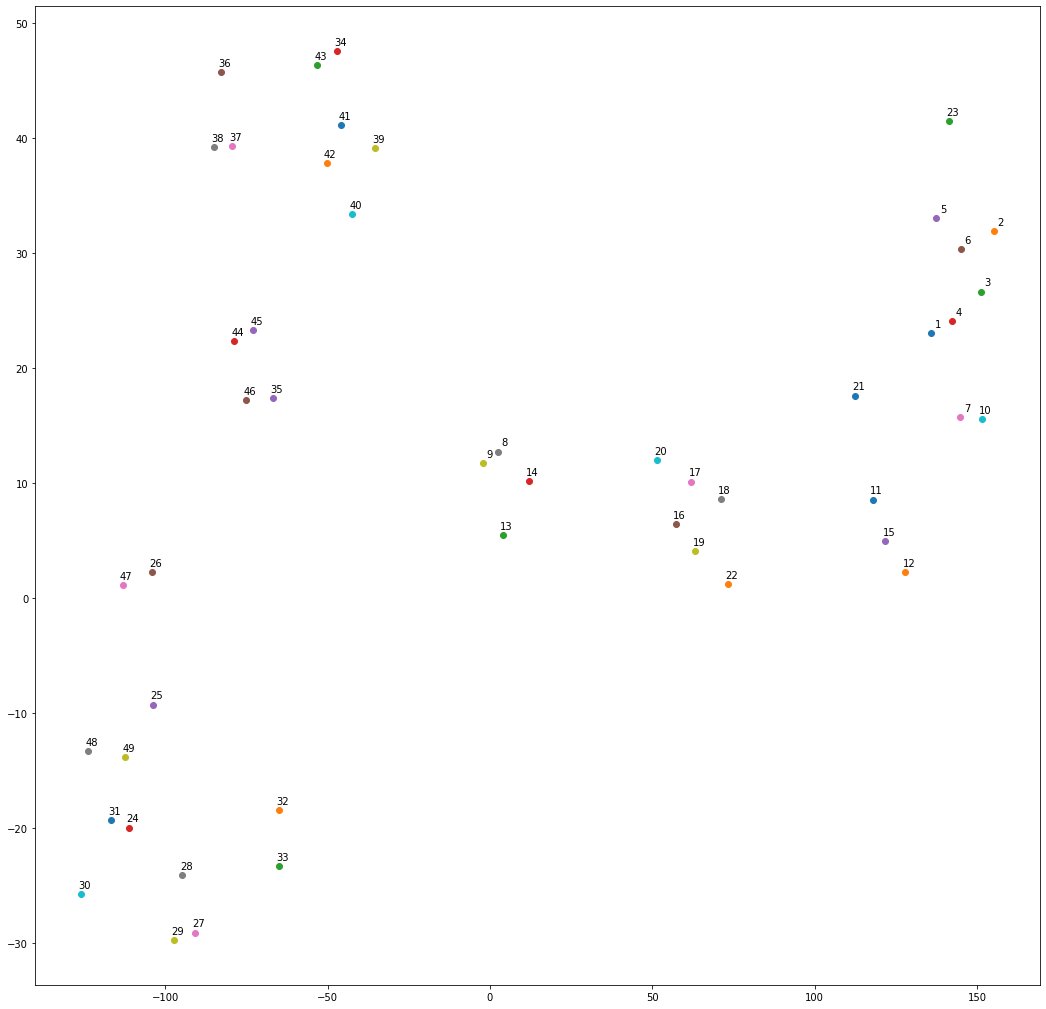

In [88]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=5, n_components=2, init="pca", n_iter=2000)
plot_only = 50
coords = tsne.fit_transform(result_matrix[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [i for i in range(1, 50)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")

plt.show()

We see that SVD is trying to find points closest to each other and grouping them up.

Now We want to find out how similar is each game to other games using user "taste" . To do that, we will use Pearson’s R correlation coefficient 

For each game, we will calculate how similar they correlate, based on the user perspective.

In [89]:
corr_mat = np.corrcoef(result_matrix)


Now lets ask user to rate games and isolate those games that the user played and rated

In [90]:
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")

In [92]:
#Fav_Games = input("Type in the games you play and the rating (0-10)(e.g Counter-Strike,9.5): ")
#Fav_Games = Fav_Games.split(",")
gameData = pd.read_csv("../SteamUserData/App_ID_Info.csv")


Fav_Games = input("Type in the game you play and the rating (0-10)(e.g Counter-Strike,9.5): ")
Fav_Games = Fav_Games.split(",")


idOfGame = gameData['gamesid'].loc[gameData['appName'] == Fav_Games[0]]

    
game_id = rating_crosstab.columns
game_id = list(game_id)

star_wars = game_id.index(idOfGame.iloc[0])
star_wars

0

In [99]:
## isolating the array that represents games played
listOfGameId = []
corr_star_wars = corr_mat[star_wars]
#list(corr_star_wars)
fullList = list(corr_star_wars)
listOfcorr = list(corr_star_wars[(corr_star_wars < 1.0) & (corr_star_wars > 0.8)])
#highestCorr = max(listOfcorr)

#indexHigh = fullList.index(highestCorr)
#indexHigh

#listOfGameId.append(game_id[indexHigh])

#listOfGameId
counter = 0;
print("Games that you might like (Recommendation) : ")
listOfcorr
for x in listOfcorr:
    indexOfitem = fullList.index(x)
    nameOfGame = gameData['appName'].loc[gameData['gamesid'] == game_id[indexOfitem]]
    print(nameOfGame.iloc[0])
    counter +=1;


Games that you might like (Recommendation) : 
Team Fortress Classic
Day of Defeat
Deathmatch Classic
Half-Life: Opposing Force
Ricochet
Half-Life
Half-Life: Blue Shift
Half-Life 2
Counter-Strike: Source
Half-Life 2: Deathmatch
Counter-Strike: Global Offensive
